# Car classification



In [1]:
!nvidia-smi

Sun Mar 28 15:35:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1


Работаем уже с Tensorflow 2.4

In [3]:
!pip freeze > requirements.txt

In [4]:
tf.keras.backend.clear_session()

# Setup

In [5]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS               = 8
BATCH_SIZE           = 16
LR                   = 1e-4
VAL_SPLIT            = 0.15 #15%

CLASS_NUM            = 10
IMG_SIZE             = 224
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/"

In [6]:
# Setting seed for reproducibility
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [10]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.sample(10)

,Id,Category
4967,288579.jpg,2
13304,186171.jpg,8
733,189956.jpg,0
14681,153950.jpg,9
14246,288283.jpg,8
7226,1898.jpg,4
14752,167358.jpg,9
12161,237493.jpg,7
4195,184943.jpg,2
14060,267711.jpg,8


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [12]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

<AxesSubplot:>

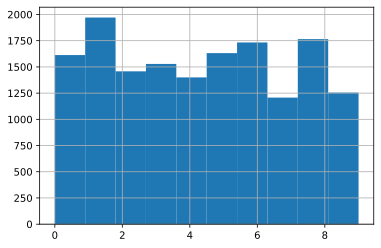

In [14]:
train_df.Category.hist()

In [15]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


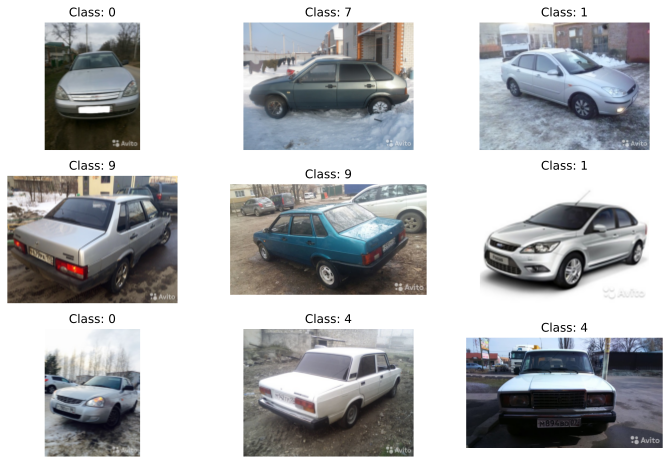

In [17]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

Вероятно классы означают модели автомобилей ВАЗ. Перейдем к подготовке данных

In [ ]:
sample_submission

# Data

### Data augmentation

In [19]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)
# Поиграйся тут параметрами чтоб понять что к чему. 
# Официальная дока https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
    rotation_range = 30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True)

## TODO - Albumentation
# Задание для Про - попробуй подключить сторонние более продвинутые библиотеки аугминтации изображений

### datagen

In [20]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# кстати, ты заметил, что для сабмишена мы используем другой источник для генератора flow_from_dataframe? 
# Как ты думаешь, почему?

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


# Model

### подгружаем предобученую сеть Xception

In [ ]:
# Кстати Попробуй еще другие архитектуры сетей...
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
base_model.summary()

In [ ]:
# Устанавливаем новую "голову"
# Тут тоже можно поиграться, попробуй добавить Batch Normalization например.

for layer in base_model.layers [:50]:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x) #моя добавка
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# ВСТАВКА fine-tuning только для последних слоев
for layer in base_model.layers[-30:]:
    # батч норм должен настраивать свои параметры для новых данных! а иначе фиксируем слой!
    if not isinstance(layer, BatchNormalization):
        layer.trainable = False


# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

 
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
model.summary()

## Fit

In [ ]:
# Рекомендую добавть еще функции из https://keras.io/callbacks/
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

# Для про - попробуй добавить разные техники управления Learning Rate
# Например:
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6
# http://teleported.in/posts/cyclic-learning-rate/

In [ ]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

# попробуй применить transfer learning с fine-tuning
# Сначала замораживаем все слои кроме новой "головы"
# Потом, когда мы научили последние слои (голову) под новую задачу, можно разморозить все слои и пройтись маленьким лернинг рейтом

In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Submission

In [ ]:
test_sub_generator.samples

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

# Для Про - попробуй добавить TTA
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

In [ ]:
submission.head()

In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

## Интересно, к какому классу модель отнесет вот этот авто:
![](http://kvu.su/upload/iblock/e3a/e3a32ed064fd71e4ce99b7f57d2de745.jpg)

# Что можно сделать, чтоб улучшить результат:
* Подобрать LR, optimizer, loss
* Добавить аугментацию
* Поиграться с архитектурой
* Подобрать другие переменные (размер картинки, батч и тп)
* Добавить политику обучения
* Добавить TTA
* Найти и обучиться на других внешних данных
* Построить ансамбль из разных архитектур

### Удачи в соревновании!

In [ ]:
# сколько слоев
print(len(base_model.layers))